In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [3]:
#connect datasets
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
sample_submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

In [4]:
#output first 10 rows of train data
pd.options.display.max_columns = 200
np.random.seed(42)
train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

In [5]:
train['OverallQual'].isnull().sum()

0

In [6]:
# выбирает автоматически категориальные признаки, и считает, сколько различных вариантов данного признака существует
new_features = []
new_train = train
new_test = test
cat_features = ['BldgType', 'MSZoning']
for i in cat_features:
    # смотрим количество различных вариантов признака в train
    one_hot = pd.get_dummies(train[i])
    # добавляем его в train
    new_train = pd.concat([new_train, one_hot], axis = 1)

    new_features_train = list(one_hot)

    # смотрим количество различных вариантов признака в test
    one_hot = pd.get_dummies(test[i])
    # добавляем его в test
    new_test = pd.concat([new_test, one_hot], axis = 1)

    new_features_test = list(one_hot)

    # выбираем все существующие варианты признака из test и train
    new_features += list(set(new_features_train) & set(new_features_test))
    
    
print(new_features)

['TwnhsE', '2fmCon', 'Twnhs', '1Fam', 'Duplex', 'RH', 'C (all)', 'FV', 'RL', 'RM']


In [7]:
# оставляем столбцы, встречающиеся и в train, и в test
new_train, new_test = new_train.align(new_test, join = 'inner', axis = 1)

In [8]:
num_features = ['OverallQual', 'OverallCond', 'TotRmsAbvGrd', 'YearBuilt']
for i in num_features:
    _max = max(max(train[i]), max(test[i]))
    _min = min(min(train[i]), min(test[i]))

    new_train[i] = (train[i] - _min)/(_max - _min)
    new_test[i] = (test[i] - _min)/(_max - _min)

In [9]:
# выводим 10 первых строк датасета train
new_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,1Fam,2fmCon,Duplex,Twnhs,TwnhsE,C (all),FV,RH,RL,RM
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,0.666667,0.500,0.949275,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,0.461538,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,1,0,0,0,0,0,0,0,1,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,0.555556,0.875,0.753623,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,0.307692,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,1,0,0,0,0,0,0,0,1,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,0.666667,0.500,0.934783,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,0.307692,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,1,0,0,0,0,0,0,0,1,0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,0.666667,0.500,0.311594,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,0.384615,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,1,0,0,0,0,0,0,0,1,0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,0.777778,0.500,0.927536,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,0.538462,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,1,0,0,0,0,0,0,0,1,0
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,0.444444,0.500,0.876812,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,0.230769,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,1,0,0,0,0,0,0,0,1,0
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,0.777778,0.500,0.956522,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,0.384615,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,1,0,0,0,0,0,0,0,1,0
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,0.666667,0.625,0.731884,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,0.384615,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,1,0,0,0,0,0,0,0,1,0
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,0.666667,0.500,0.427536,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,G

In [10]:
new_train['LotAreaLog'] = np.log1p(train['LotArea'])
new_train['GrLivAreaLog'] = np.log1p(train['GrLivArea'])
new_train['1stFlrSFLog'] =  np.log1p(train['1stFlrSF'])

new_train['SalePriceLog'] =  np.log1p(train['SalePrice'])

In [11]:
new_test['LotAreaLog'] = np.log1p(test['LotArea'])
new_test['GrLivAreaLog'] = np.log1p(test['GrLivArea'])
new_test['1stFlrSFLog'] = np.log1p(test['1stFlrSF'])

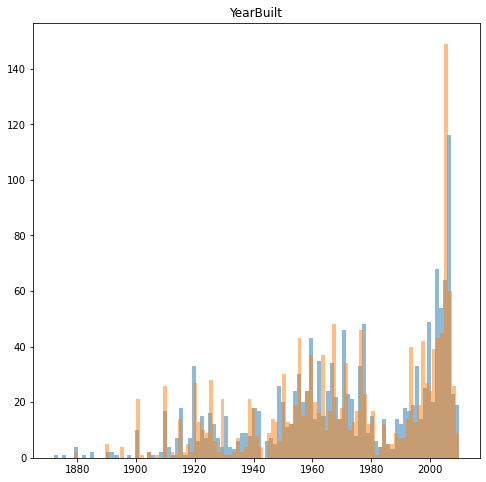

In [12]:
plt.figure(figsize= (8,8))
plt.hist(train['YearBuilt'], bins = 100, label = 'train', alpha = 0.5)
plt.hist(test['YearBuilt'], bins = 100, label = 'test', alpha = 0.5)
plt.title('YearBuilt')
plt.show()

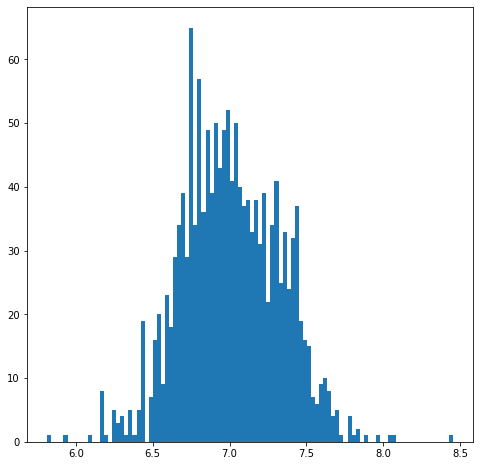

In [13]:
plt.figure(figsize= (8,8))
plt.hist(new_train['1stFlrSFLog'], bins = 100)
plt.show()

In [14]:
print(new_train.shape, new_test.shape)

(1460, 94) (1459, 93)


Были нормализованы следующие признаки: LotArea,  GrLivArea, 1stFlrSF, OverallQual, OverallCond, TotRmsAbvGrd, YearBuilt, а также закодированы категориальные признаки BldgType, MSZoning.

* LotArea показывает общую площадь в футах, что явно отражается на цене квартиры.
* GrLivArea показывает жилую площадь в футах.
* 1stFlrSF показывает общую площадь первого этажа. В случае одноэтажной квартиры совпадает с GrLivArea.
* OverallQual - оценка материала и отделки дома
* OverallCond - оценка общего состояния дома
* TotRmsAbvGrd - количество комнат (без ванны)
* YearBuilt - год постройки
* BldgType - тип жилища
* MSZoning - определяет общую классификацию объекта продажи

In [15]:
kf = KFold(n_splits=5)

model = SGDRegressor()
rmse_list = []
new_features.extend(num_features)
new_features.extend(['LotAreaLog', 'GrLivAreaLog', '1stFlrSFLog'])
print(new_features)


for i, (train_index, test_index) in enumerate(kf.split(new_train)):
    
    X_train, X_test = new_train.loc[train_index, new_features], new_train.loc[test_index, new_features]
    y_train, y_test = new_train.loc[train_index, 'SalePriceLog'], new_train.loc[test_index, 'SalePriceLog']

    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(predict,y_test))
    rmse_list.append(rmse)
    print(i, rmse)
    
print("Mean rmse for 5-fold: {}".format(str(np.mean(rmse_list))))
print("std rmse for 5-fold: {}".format(str(np.std(rmse_list))))

['TwnhsE', '2fmCon', 'Twnhs', '1Fam', 'Duplex', 'RH', 'C (all)', 'FV', 'RL', 'RM', 'OverallQual', 'OverallCond', 'TotRmsAbvGrd', 'YearBuilt', 'LotAreaLog', 'GrLivAreaLog', '1stFlrSFLog']
0 0.2127564799787672
1 0.2540045599082491
2 0.22201721946962283
3 0.23518881949179218
4 0.25879627395607163
Mean rmse for 5-fold: 0.2365526705609006
std rmse for 5-fold: 0.01776932440010374


In [16]:
model = SGDRegressor()
model.fit(new_train[new_features], new_train['SalePriceLog'])
prediction = model.predict(new_test[new_features])

In [17]:
new_test.shape

(1459, 93)

In [18]:
sample_submission['SalePrice'] =  np.expm1(prediction)
sample_submission.to_csv('submission.csv', index = None)

In [19]:
 print(max(prediction), min(prediction))

14.036853736522062 10.367640363104517


Далее следует график 5 сабмитов на kaggle с разными моделями и признаками. Использовались метрики на лидерборде (scorelist) и на кросс-валидации (rmselist).

Ошибка на кросс-валидации практически совпадает с результатами на лидерборде, что указывает на то, что модель хорошо обучилась.

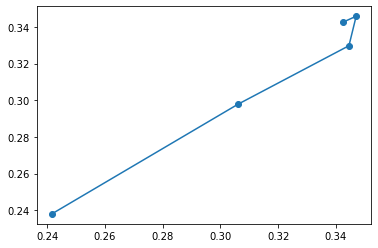

In [22]:
rmselist = [0.34245, 0.34705, 0.34455, 0.30607, 0.24157]
scorelist = [0.34260, 0.34586, 0.32977, 0.29782, 0.23798]

plt.plot(rmselist,scorelist)
plt.scatter(rmselist,scorelist)
plt.show()